In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load dataset
data_path = '/content/drive/Shareddrives/DeepLearning/Weather_LSTM_Project/data/NewYork_2023_2024_WeatherDataset.csv'
data = pd.read_csv(data_path)

# Drop unwanted columns
data.drop(columns=['name','precipprob', 'severerisk', 'description', 'icon', 'stations'], inplace=True)

# Show first few rows to confirm
data.head()


,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions
0,2023-01-01,12.4,9.7,11.1,12.4,8.0,11.0,4.4,65.6,0.307,...,1012.2,41.5,15.1,96.4,8.4,4,2023-01-01T07:20:12,2023-01-01T16:39:10,0.32,"Rain, Partially cloudy"
1,2023-01-02,13.5,8.2,11.1,13.5,6.7,10.8,4.3,63.3,0.564,...,1019.3,61.7,15.5,43.8,3.6,3,2023-01-02T07:20:17,2023-01-02T16:40:01,0.35,"Rain, Partially cloudy"
2,2023-01-03,13.1,8.2,10.7,13.1,7.3,10.5,8.8,88.3,9.908,...,1014.4,91.6,8.8,16.2,1.5,1,2023-01-03T07:20:21,2023-01-03T16:40:53,0.39,"Rain, Overcast"
3,2023-01-04,18.7,9.6,14.3,18.7,8.1,14.2,10.9,80.6,0.459,...,1009.9,72.3,13.2,59.1,5.1,3,2023-01-04T07:20:22,2023-01-04T16:41:48,0.42,"Rain, Partially cloudy"
4,2023-01-05,9.8,7.4,8.8,9.1,4.8,7.5,7.4,90.5,0.386,...,1013.4,100.0,9.2,26.9,2.3,1,2023-01-05T07:20:21,2023-01-05T16:42:43,0.46,"Rain, Overcast"


In [3]:
# Convert 'preciptype' to categorical codes
data['preciptype'] = data['preciptype'].astype('category').cat.codes

# Convert 'conditions' to categorical codes
data['conditions'] = data['conditions'].astype('category').cat.codes

# Check mappings
preciptype_mapping = dict(enumerate(data['preciptype'].astype('category').cat.categories))
conditions_mapping = dict(enumerate(data['conditions'].astype('category').cat.categories))


# Show mappings
print("PrecipType Mapping:", preciptype_mapping)
print("Conditions Mapping:", conditions_mapping)

PrecipType Mapping: {0: -1, 1: 0, 2: 1, 3: 2}
Conditions Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


In [4]:
# Converted sunrise and sunset values into minutes

# Convert sunrise and sunset columns to datetime format
data['sunrise'] = pd.to_datetime(data['sunrise'])
data['sunset'] = pd.to_datetime(data['sunset'])

# Convert to minutes since midnight
data['sunrise_minutes'] = data['sunrise'].dt.hour * 60 + data['sunrise'].dt.minute
data['sunset_minutes'] = data['sunset'].dt.hour * 60 + data['sunset'].dt.minute

# Drop original columns if no longer needed
data.drop(columns=['sunrise', 'sunset'], inplace=True)

# Show updated data
data[['sunrise_minutes', 'sunset_minutes']].head()

data.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,conditions,sunrise_minutes,sunset_minutes
0,2023-01-01,12.4,9.7,11.1,12.4,8.0,11.0,4.4,65.6,0.307,...,1012.2,41.5,15.1,96.4,8.4,4,0.32,5,440,999
1,2023-01-02,13.5,8.2,11.1,13.5,6.7,10.8,4.3,63.3,0.564,...,1019.3,61.7,15.5,43.8,3.6,3,0.35,5,440,1000
2,2023-01-03,13.1,8.2,10.7,13.1,7.3,10.5,8.8,88.3,9.908,...,1014.4,91.6,8.8,16.2,1.5,1,0.39,4,440,1000
3,2023-01-04,18.7,9.6,14.3,18.7,8.1,14.2,10.9,80.6,0.459,...,1009.9,72.3,13.2,59.1,5.1,3,0.42,5,440,1001
4,2023-01-05,9.8,7.4,8.8,9.1,4.8,7.5,7.4,90.5,0.386,...,1013.4,100.0,9.2,26.9,2.3,1,0.46,4,440,1002


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Drop any rows with missing values if needed
# data.dropna(inplace=True)

# Choose your input features and target
features = ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin','feelslike', 'dew',
            'humidity', 'precip', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
            'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
            'visibility', 'solarradiation', 'solarenergy', 'uvindex',
            'conditions', 'sunrise_minutes', 'sunset_minutes', 'moonphase']
target = 'temp'  # what you want to predict

# Scale input and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(data[features])
y_scaled = scaler_y.fit_transform(data[[target]])

# Convert to sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 31  # Number of days to look back
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

print("X shape:", X_seq.shape)  # (num_samples, seq_len, num_features)
print("y shape:", y_seq.shape)  # (num_samples, 1)


X shape: (700, 31, 25)
y shape: (700, 1)


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [7]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        out = self.fc(output[:, -1, :])  # Take the output from the last time step
        return out


Epoch 1/100, MSE: 0.1278, MAE: 0.2839
Epoch 2/100, MSE: 0.0276, MAE: 0.1380
Epoch 3/100, MSE: 0.0130, MAE: 0.0919
Epoch 4/100, MSE: 0.0090, MAE: 0.0744
Epoch 5/100, MSE: 0.0080, MAE: 0.0704
Epoch 6/100, MSE: 0.0073, MAE: 0.0664
Epoch 7/100, MSE: 0.0075, MAE: 0.0676
Epoch 8/100, MSE: 0.0074, MAE: 0.0670
Epoch 9/100, MSE: 0.0066, MAE: 0.0622
Epoch 10/100, MSE: 0.0067, MAE: 0.0630
Epoch 11/100, MSE: 0.0064, MAE: 0.0623
Epoch 12/100, MSE: 0.0061, MAE: 0.0605
Epoch 13/100, MSE: 0.0060, MAE: 0.0604
Epoch 14/100, MSE: 0.0059, MAE: 0.0587
Epoch 15/100, MSE: 0.0059, MAE: 0.0590
Epoch 16/100, MSE: 0.0055, MAE: 0.0573
Epoch 17/100, MSE: 0.0054, MAE: 0.0569
Epoch 18/100, MSE: 0.0056, MAE: 0.0579
Epoch 19/100, MSE: 0.0054, MAE: 0.0580
Epoch 20/100, MSE: 0.0051, MAE: 0.0561
Epoch 21/100, MSE: 0.0048, MAE: 0.0537
Epoch 22/100, MSE: 0.0047, MAE: 0.0532
Epoch 23/100, MSE: 0.0049, MAE: 0.0547
Epoch 24/100, MSE: 0.0047, MAE: 0.0534
Epoch 25/100, MSE: 0.0047, MAE: 0.0536
Epoch 26/100, MSE: 0.0047, MAE: 0.

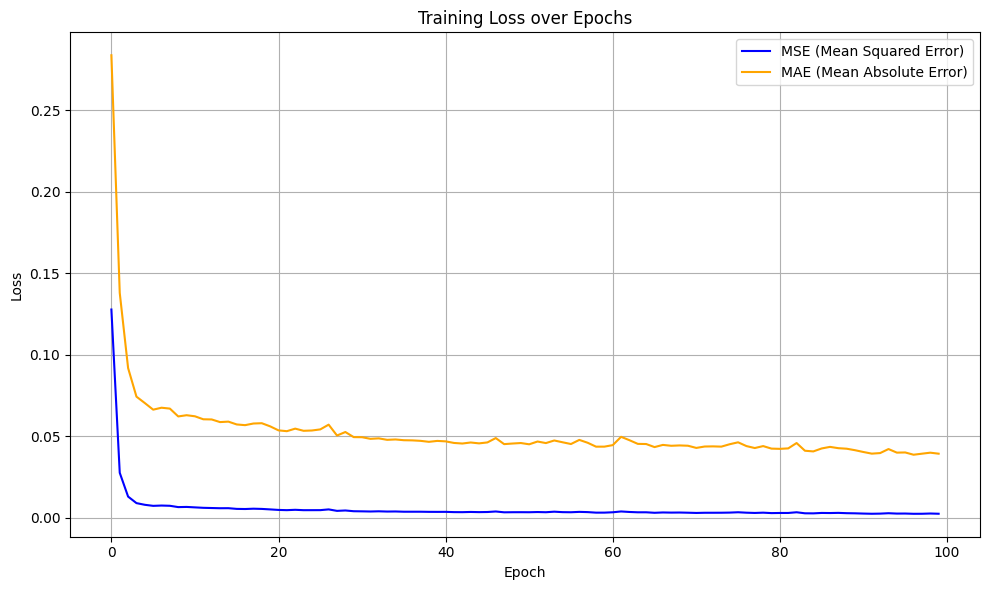

In [8]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Flatten for models that expect 2D input
X_flat_train = X_train.reshape(X_train.shape[0], -1)
X_flat_test = X_test.reshape(X_test.shape[0], -1)
# Inverse transform target for evaluation
y_true_eval = scaler_y.inverse_transform(y_test)


train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model
model = LSTMModel(input_size=X_seq.shape[2], hidden_size=64, num_layers=2)
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()          # For tracking
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_mse_losses = []
train_mae_losses = []

# Training loop
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_mae = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_mae += mae_fn(y_pred, y_batch).item()

    avg_mse = epoch_loss / len(train_loader)
    avg_mae = epoch_mae / len(train_loader)

    train_mse_losses.append(avg_mse)
    train_mae_losses.append(avg_mae)
    print(f"Epoch {epoch+1}/{EPOCHS}, MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_mse_losses, label='MSE (Mean Squared Error)', color='blue')
plt.plot(train_mae_losses, label='MAE (Mean Absolute Error)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        all_preds.append(y_pred.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

all_preds = np.vstack(all_preds)       # shape (num_samples, 1)
all_targets = np.vstack(all_targets)   # shape (num_samples, 1)

# Make sure to reshape if necessary
all_preds = all_preds.reshape(-1, 1)
all_targets = all_targets.reshape(-1, 1)

# Inverse transform predictions and targets
y_pred_inv = scaler_y.inverse_transform(all_preds)
y_true_inv = scaler_y.inverse_transform(all_targets)

rnn_mae = mean_absolute_error(y_true_inv, y_pred_inv)
rnn_mse = mean_squared_error(y_true_inv, y_pred_inv)

r2 = r2_score(y_true_inv, y_pred_inv)
print(f"Test R² score: {r2:.4f}")
print(f"Test MAE : {rnn_mae:.4f}")
print(f"Test MSE : {rnn_mse:.4f}")


Test R² score: 0.8875
Test MAE : 2.0876
Test MSE : 6.9067


In [10]:

model.eval()
predictions = []
actuals = []
sequence_dates = []

with torch.no_grad():
    for i in range(len(X_test)):
        input_seq = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, features)
        pred = model(input_seq).numpy()
        predictions.append(pred[0])
        actuals.append(y_test[i])
        # Save the dates used to create this sequence
        date_range = pd.to_datetime(data['datetime'].values[len(X_train) + i : len(X_train) + i + SEQ_LENGTH + 1])
        sequence_dates.append(date_range)

# Inverse scale predictions and actuals
predicted_temps = scaler_y.inverse_transform(np.array(predictions))
actual_temps = scaler_y.inverse_transform(np.array(actuals))

# Show results for first 5 examples
for i in range(5):
    print(f"\nSample {i+1}")
    print("-" * 30)
    print("Previous dates used:")
    for d in sequence_dates[i][:-1]:
        print("  ", pd.to_datetime(d).strftime("%Y-%m-%d"))
    print("Prediction date:", pd.to_datetime(sequence_dates[i][-1]).strftime("%Y-%m-%d"))
    print(f"Predicted temp: {predicted_temps[i][0]:.2f}")
    print(f"Actual temp:    {actual_temps[i][0]:.2f}")
    print(f"Difference:     {abs(predicted_temps[i][0] - actual_temps[i][0]):.2f}")



Sample 1
------------------------------
Previous dates used:
   2024-07-14
   2024-07-15
   2024-07-16
   2024-07-17
   2024-07-18
   2024-07-19
   2024-07-20
   2024-07-21
   2024-07-22
   2024-07-23
   2024-07-24
   2024-07-25
   2024-07-26
   2024-07-27
   2024-07-28
   2024-07-29
   2024-07-30
   2024-07-31
   2024-08-01
   2024-08-02
   2024-08-03
   2024-08-04
   2024-08-05
   2024-08-06
   2024-08-07
   2024-08-08
   2024-08-09
   2024-08-10
   2024-08-11
   2024-08-12
   2024-08-13
Prediction date: 2024-08-14
Predicted temp: 24.11
Actual temp:    24.70
Difference:     0.59

Sample 2
------------------------------
Previous dates used:
   2024-07-15
   2024-07-16
   2024-07-17
   2024-07-18
   2024-07-19
   2024-07-20
   2024-07-21
   2024-07-22
   2024-07-23
   2024-07-24
   2024-07-25
   2024-07-26
   2024-07-27
   2024-07-28
   2024-07-29
   2024-07-30
   2024-07-31
   2024-08-01
   2024-08-02
   2024-08-03
   2024-08-04
   2024-08-05
   2024-08-06
   2024-08-07
   2024-08-08

In [11]:
#Gaussian Regressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, mean_absolute_error


kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

print("Training Gaussian Process...")
gpr.fit(X_flat_train, y_train.ravel())

print("Predicting with GPR...")
y_pred_gp = gpr.predict(X_flat_test).reshape(-1, 1)
y_pred_gp = scaler_y.inverse_transform(y_pred_gp)

actual_temps = scaler_y.inverse_transform(y_test)

# Evaluate GPR on test set
gpr_mse = mean_squared_error(actual_temps, y_pred_gp)
gpr_mae = mean_absolute_error(actual_temps, y_pred_gp)
gpr_r2 = r2_score(actual_temps, y_pred_gp)

print(f"\nGaussian Process Regressor Performance:")
print(f"Test MSE: {gpr_mse:.4f}")
print(f"Test MAE: {gpr_mae:.4f}")
print(f"Test R² score: {gpr_r2:.4f}")

Training Gaussian Process...
Predicting with GPR...

Gaussian Process Regressor Performance:
Test MSE: 10.7245
Test MAE: 2.6328
Test R² score: 0.8253


In [12]:
#Xboost model
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1)

print("Training XGBoost...")
xgb_model.fit(X_flat_train, y_train.ravel())

print("Predicting with XGBoost...")
y_pred_xgb = xgb_model.predict(X_flat_test).reshape(-1, 1)
y_pred_xgb = scaler_y.inverse_transform(y_pred_xgb)

xgb_mae = mean_absolute_error(actual_temps, y_pred_xgb)
xgb_mse = mean_squared_error(actual_temps, y_pred_xgb)
xgb_r2 = r2_score(actual_temps, y_pred_xgb)

print(f"XGBoost Performance:")
print(f"Test MSE: {xgb_mse:.4f}")
print(f"Test MAE: {xgb_mae:.4f}")
print(f"Test R² score: {xgb_r2:.4f}")

Training XGBoost...
Predicting with XGBoost...
XGBoost Performance:
Test MSE: 9.5781
Test MAE: 2.4186
Test R² score: 0.8439


In [13]:
#Simple RNN
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

X_rnn_train = torch.tensor(X_train, dtype=torch.float32)
y_rnn_train = torch.tensor(y_train, dtype=torch.float32)
X_rnn_test = torch.tensor(X_test, dtype=torch.float32)

train_rnn_loader = DataLoader(TensorDataset(X_rnn_train, y_rnn_train), batch_size=32, shuffle=False)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

model_rnn = SimpleRNN(input_size=X_train.shape[2], hidden_size=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

EPOCHS = 100
print("Training Simple RNN...")
for epoch in range(EPOCHS):
    model_rnn.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_rnn(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluation (same as LSTM)
model_rnn.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model_rnn(X_batch)
        all_preds.append(preds.numpy())
        all_targets.append(y_batch.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Inverse scaling your predictions and targets
y_pred_rnn = scaler_y.inverse_transform(all_preds)
y_true_inv = scaler_y.inverse_transform(all_targets)
rnn_r2 = r2_score(y_true_inv, y_pred_rnn)

print(f"Simple RNN Performance:")
print(f"Simple RNN Test MSE: {mean_squared_error(y_true_inv, y_pred_rnn):.4f}")
print(f"Simple RNN Test MAE: {mean_absolute_error(y_true_inv, y_pred_rnn):.4f}")
print(f"Simple RNN Test R² score: {rnn_r2:.4f}")

Training Simple RNN...
Epoch 1/100, Loss: 0.0967
Epoch 2/100, Loss: 0.0229
Epoch 3/100, Loss: 0.0107
Epoch 4/100, Loss: 0.0082
Epoch 5/100, Loss: 0.0075
Epoch 6/100, Loss: 0.0071
Epoch 7/100, Loss: 0.0067
Epoch 8/100, Loss: 0.0063
Epoch 9/100, Loss: 0.0063
Epoch 10/100, Loss: 0.0056
Epoch 11/100, Loss: 0.0054
Epoch 12/100, Loss: 0.0053
Epoch 13/100, Loss: 0.0050
Epoch 14/100, Loss: 0.0049
Epoch 15/100, Loss: 0.0047
Epoch 16/100, Loss: 0.0048
Epoch 17/100, Loss: 0.0047
Epoch 18/100, Loss: 0.0046
Epoch 19/100, Loss: 0.0045
Epoch 20/100, Loss: 0.0045
Epoch 21/100, Loss: 0.0042
Epoch 22/100, Loss: 0.0041
Epoch 23/100, Loss: 0.0042
Epoch 24/100, Loss: 0.0041
Epoch 25/100, Loss: 0.0042
Epoch 26/100, Loss: 0.0039
Epoch 27/100, Loss: 0.0040
Epoch 28/100, Loss: 0.0039
Epoch 29/100, Loss: 0.0038
Epoch 30/100, Loss: 0.0038
Epoch 31/100, Loss: 0.0038
Epoch 32/100, Loss: 0.0038
Epoch 33/100, Loss: 0.0038
Epoch 34/100, Loss: 0.0037
Epoch 35/100, Loss: 0.0037
Epoch 36/100, Loss: 0.0035
Epoch 37/100, 

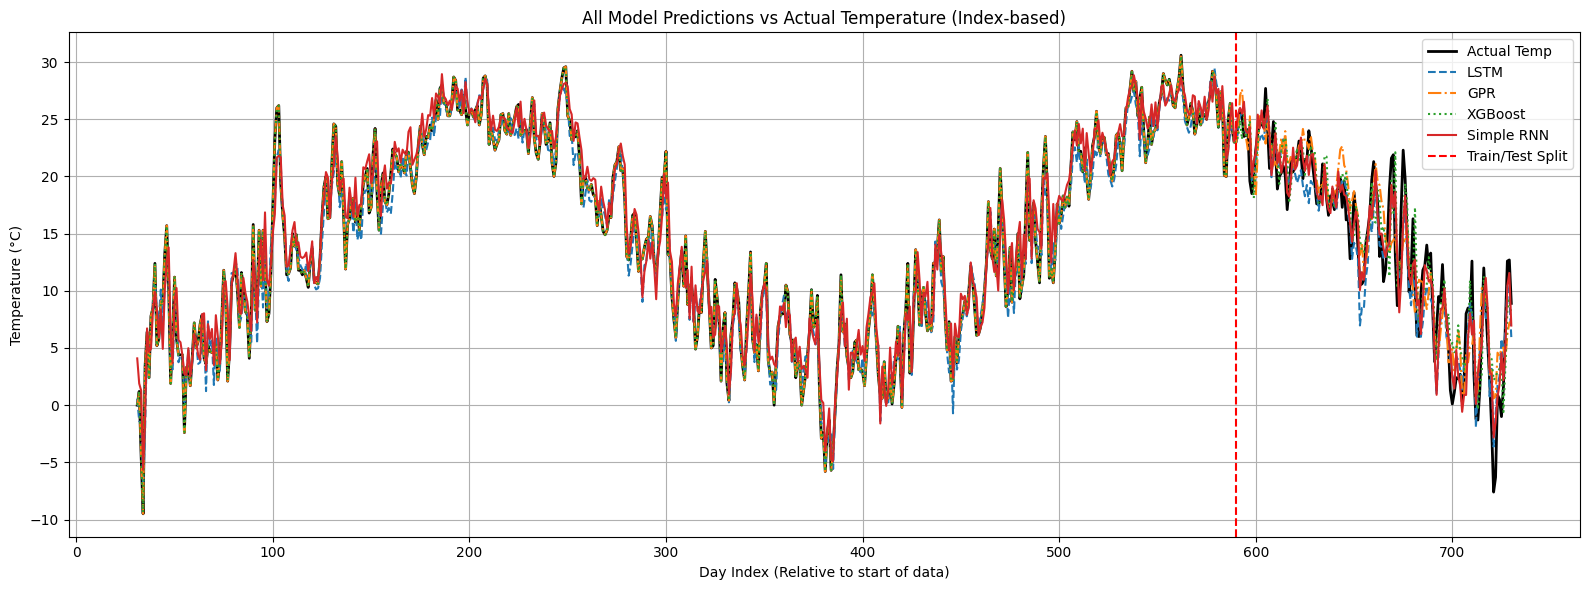

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct full index range for predictions
# The indices should simply correspond to the index within y_seq
# after accounting for the sequence length offset.
# y_seq has length len(data) - SEQ_LENGTH

start_index = SEQ_LENGTH  # The first prediction corresponds to day index SEQ_LENGTH in original data

# Indices for plotting relative to the start of the sequences (after day SEQ_LENGTH-1)
train_plot_indices = np.arange(len(y_train))
test_plot_indices = np.arange(len(y_train), len(y_train) + len(y_test))
all_plot_indices = np.arange(len(y_seq)) # This is equivalent to np.concatenate([train_plot_indices, test_plot_indices])

# Get predictions for the training set for all models
# (These variables were causing NameError)
model.eval()
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    lstm_preds_train = model(X_train_tensor).numpy()

gpr_preds_train = gpr.predict(X_flat_train).reshape(-1, 1)
xgb_preds_train = xgb_model.predict(X_flat_train).reshape(-1, 1)
model_rnn.eval()
with torch.no_grad():
    X_rnn_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    rnn_preds_train = model_rnn(X_rnn_train_tensor).numpy()


# Inverse transform training set predictions as well
lstm_preds_train = scaler_y.inverse_transform(lstm_preds_train)
gpr_preds_train = scaler_y.inverse_transform(gpr_preds_train)
xgb_preds_train = scaler_y.inverse_transform(xgb_preds_train)
rnn_preds_train = scaler_y.inverse_transform(rnn_preds_train)

# Inverse transform the actual training targets for plotting
y_train_actual = scaler_y.inverse_transform(y_train)

# Combine actual values for plotting (train and test)
y_all_actual_combined = np.concatenate([y_train_actual, actual_temps]) # actual_temps is already inverse scaled y_test

# Combined predictions per model (train and test)
lstm_all = np.concatenate([lstm_preds_train, predicted_temps])
gpr_all = np.concatenate([gpr_preds_train, y_pred_gp])
xgb_all = np.concatenate([xgb_preds_train, y_pred_xgb])
rnn_all = np.concatenate([rnn_preds_train, y_pred_rnn])


# Plot
plt.figure(figsize=(16, 6))

# Plotting against the indices relative to the start of sequences (day index SEQ_LENGTH in original data)
plt.plot(all_plot_indices + start_index, y_all_actual_combined, label='Actual Temp', color='black', linewidth=2) # Adjust x-axis to reflect original data index

plt.plot(all_plot_indices + start_index, lstm_all, label='LSTM', linestyle='--')
plt.plot(all_plot_indices + start_index, gpr_all, label='GPR', linestyle='-.')
plt.plot(all_plot_indices + start_index, xgb_all, label='XGBoost', linestyle=':')
plt.plot(all_plot_indices + start_index, rnn_all, label='Simple RNN', linestyle='-')

# Split line
plt.axvline(x=len(y_train) + start_index -1 , color='red', linestyle='--', label='Train/Test Split') # Adjust split line position

plt.title('All Model Predictions vs Actual Temperature (Index-based)')
# The x-axis label should probably reflect the day number starting from 0 for the first day of data
plt.xlabel(f'Day Index (Relative to start of data)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

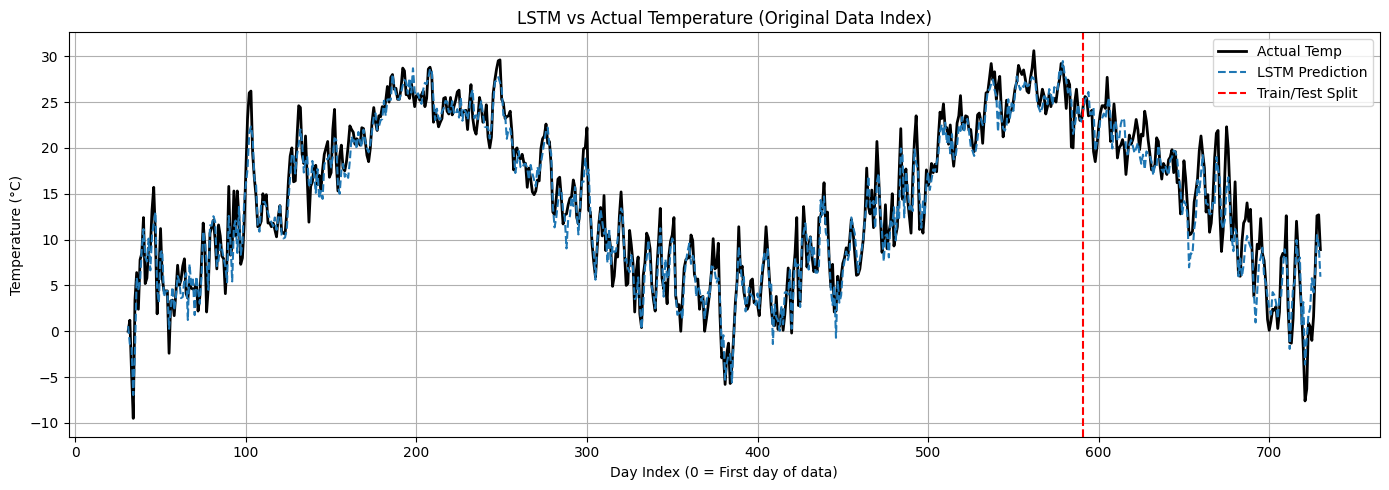

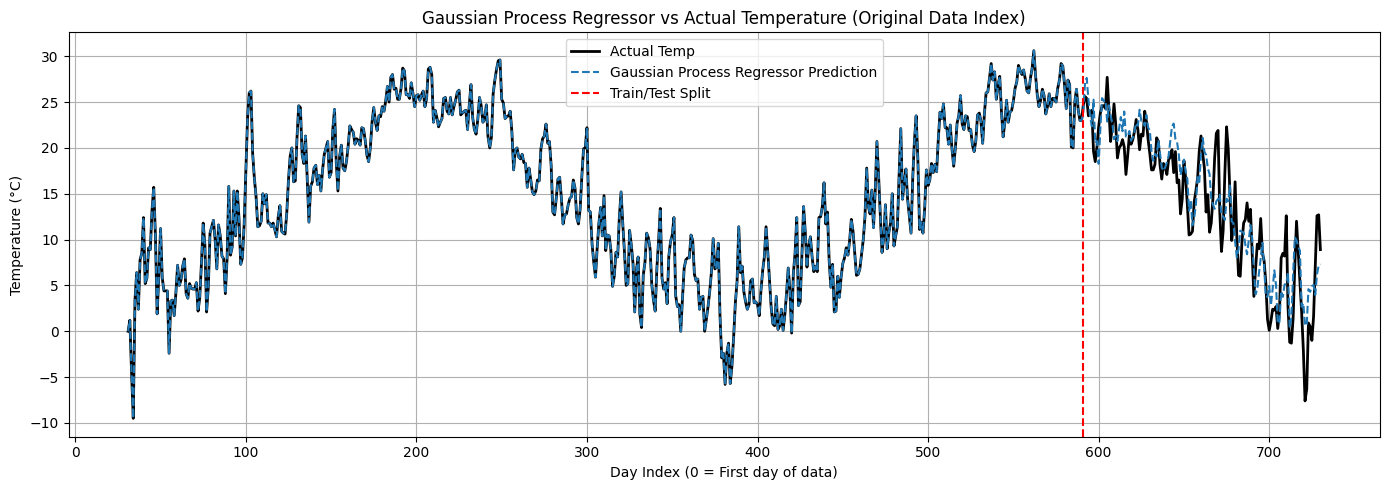

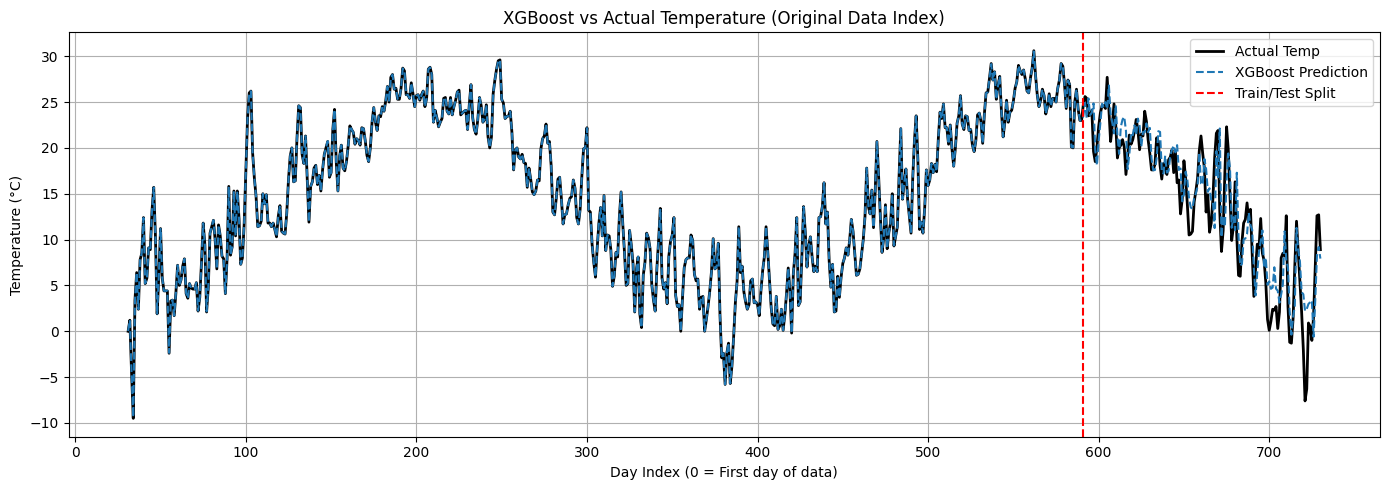

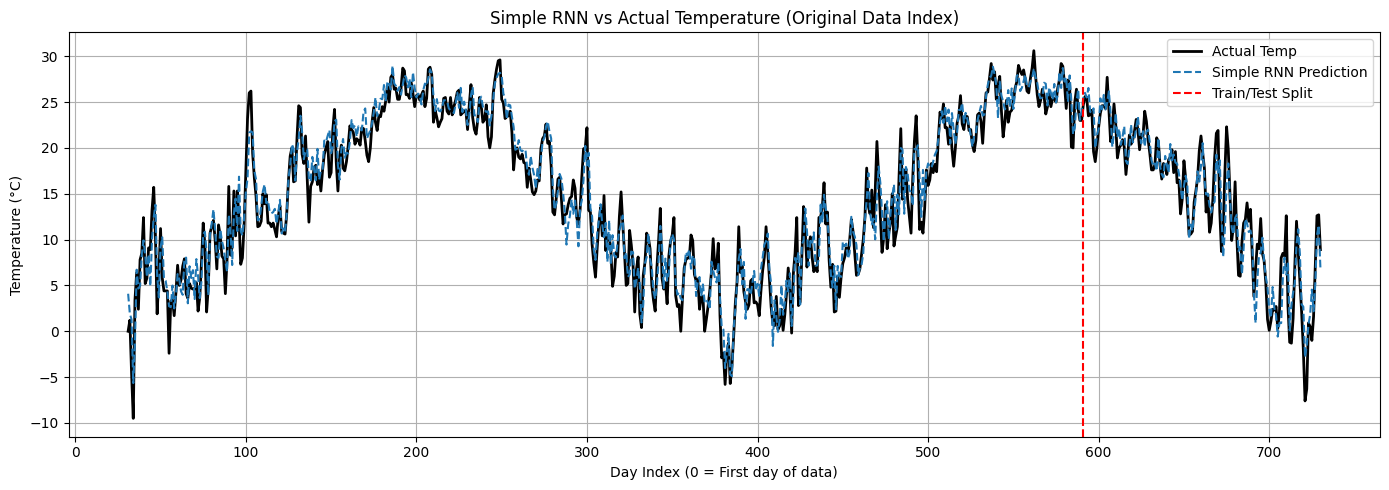

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct full index range for predictions
# These indices correspond to the original data index for the predicted day
start_index = SEQ_LENGTH  # first prediction corresponds to original data index SEQ_LENGTH
all_indices = np.arange(start_index, start_index + len(y_seq))

# Actual full targets (already computed in previous cell)
y_all_actual = scaler_y.inverse_transform(y_seq) # Already computed in ipython-input-24

# Need the full range of indices for y_all_actual itself (0 to len(y_seq)-1)
y_all_actual_indices = np.arange(len(y_all_actual))

def plot_model_predictions_index(preds_train, preds_test, model_name):
    all_preds = np.concatenate([preds_train, preds_test])
    plt.figure(figsize=(14, 5))

    # Plot actual temps using y_all_actual and the original data indices
    # Index y_all_actual with its own indices (0 to len(y_seq)-1)
    plt.plot(all_indices, y_all_actual[y_all_actual_indices], label='Actual Temp', color='black', linewidth=2)

    # Plot predictions against the same original data indices
    plt.plot(all_indices, all_preds.ravel(), label=f'{model_name} Prediction', linestyle='--') # Use ravel for 1D array

    # Calculate the split point index based on the length of the training set relative to y_seq
    split_index_on_all_indices = start_index + len(y_train) # This is the original data index where test set starts

    plt.axvline(x=split_index_on_all_indices, color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'{model_name} vs Actual Temperature (Original Data Index)')
    plt.xlabel(f'Day Index (0 = First day of data)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Note: The variables lstm_preds_train, predicted_temps, gpr_preds_train, y_pred_gp,
# xgb_preds_train, y_pred_xgb, rnn_preds_train, y_pred_rnn, and y_all_actual
# are assumed to be computed and available from the previous cells (specifically ipython-input-24).

# LSTM
plot_model_predictions_index(lstm_preds_train, predicted_temps, 'LSTM')

# GPR
plot_model_predictions_index(gpr_preds_train, y_pred_gp, 'Gaussian Process Regressor')

# XGBoost
plot_model_predictions_index(xgb_preds_train, y_pred_xgb, 'XGBoost')

# Simple RNN
plot_model_predictions_index(rnn_preds_train, y_pred_rnn, 'Simple RNN')

In [16]:
# SHAP to measure importance of features.
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_flat_test)

Number of original features: 25
Sequence length: 31
Expected number of flattened features: 775
Number of generated feature names: 775
Number of features in X_flat_test: 775


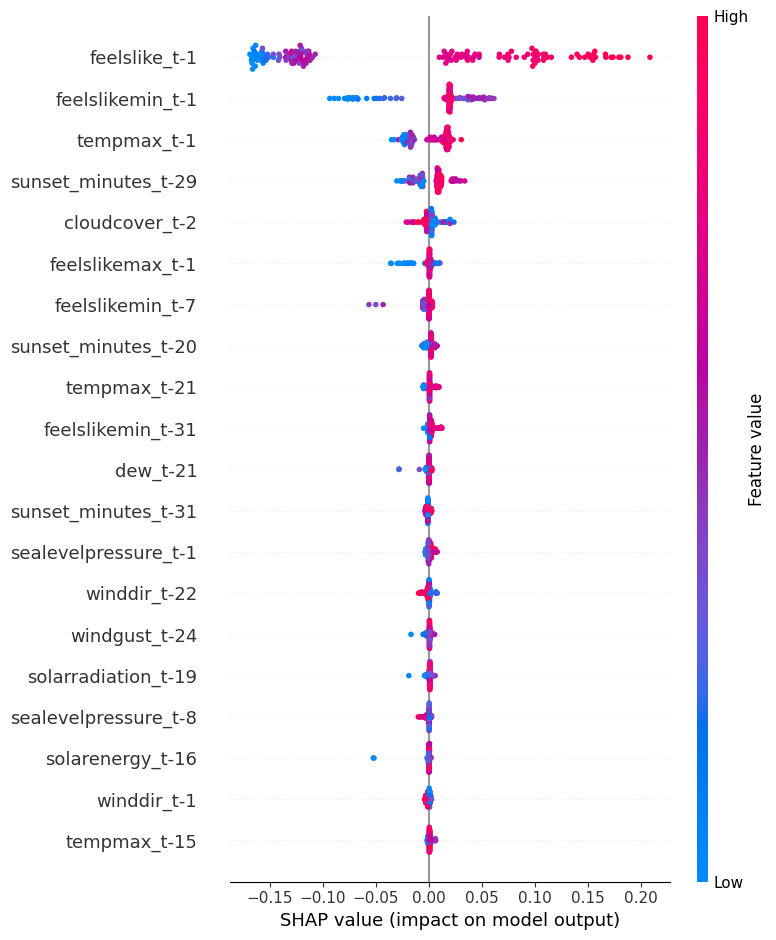

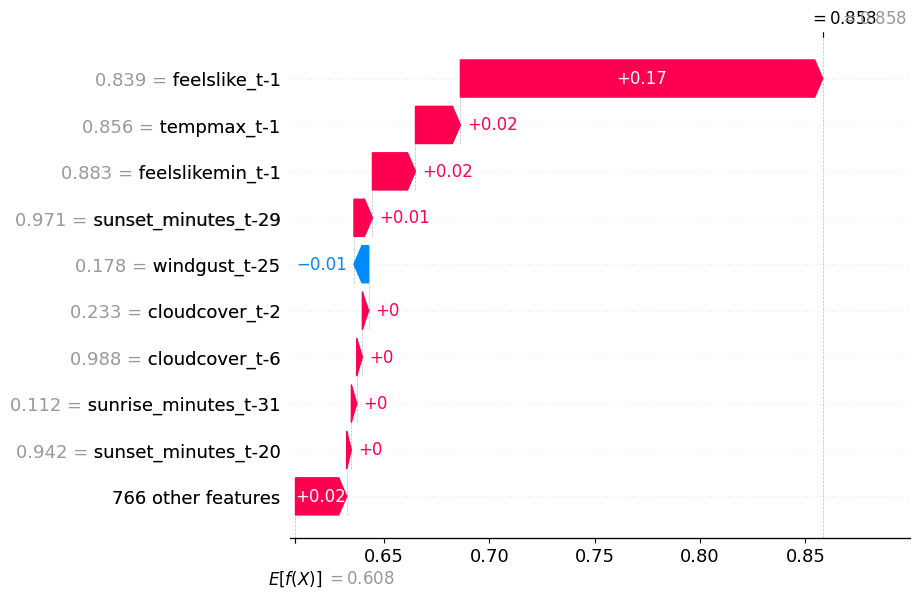

In [17]:
# SHAP to measure importance of features.
import shap
import matplotlib.pyplot as plt

# Create the explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
# This line was already executed in previous cell, but re-executing is fine
shap_values = explainer(X_flat_test)

# Example input:
SEQ_LENGTH = X_train.shape[1]
N_FEATURES = X_train.shape[2]

# Get the actual feature names used in the model
# This list was defined earlier when preparing data for the model
original_feature_names = features # Use the 'features' list defined earlier

# Correctly generate flattened feature names based on the actual features and sequence length
flattened_feature_names = [
    f"{feature}_t-{SEQ_LENGTH - t}"
    for t in range(SEQ_LENGTH)
    for feature in original_feature_names
]

# Verify the number of generated feature names matches the number of flattened features
print(f"Number of original features: {N_FEATURES}")
print(f"Sequence length: {SEQ_LENGTH}")
print(f"Expected number of flattened features: {N_FEATURES * SEQ_LENGTH}")
print(f"Number of generated feature names: {len(flattened_feature_names)}")
print(f"Number of features in X_flat_test: {X_flat_test.shape[1]}")

# Assign feature names to the shap_values object
# Ensure the number of feature names matches the number of columns in X_flat_test
if len(flattened_feature_names) == X_flat_test.shape[1]:
    shap_values.feature_names = flattened_feature_names
else:
    print("Warning: Number of generated feature names does not match the number of features in X_flat_test.")
    print("Waterfall plot might not display correct feature names.")


# Global feature importance plot with corrected feature names
# shap.summary_plot uses the feature names directly from the Explanation object now
shap.summary_plot(shap_values, X_flat_test)

# Individual prediction explanation (optional, but good for demonstration)
sample_index = 1
# The waterfall plot now reads feature names directly from the shap_values object
shap.plots.waterfall(shap_values[sample_index])